<a href="https://colab.research.google.com/github/raphaelp-silva/GNN_Pytorch_geometric/blob/main/Graphs_obesity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [48]:
!pip install faiss-cpu
!pip install torch_geometric

In [49]:
from torch_geometric.data import Data
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
import torch
import faiss
import networkx as nx


In [50]:
import kagglehub

# Fazendo o download da ultima versão via api
path = kagglehub.dataset_download("adeniranstephen/obesity-prediction-dataset")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/adeniranstephen/obesity-prediction-dataset/versions/1


In [51]:
os.listdir(path) #listando os arquivos do diretorio

db = pd.read_csv(os.path.join(path, "ObesityDataSet_raw_and_data_sinthetic.csv"))

In [52]:
db.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


In [53]:
# Convertendo colunas (yes/no) para valores binários:

colunas_binarias = ['family_history_with_overweight', 'FAVC', 'SMOKE', 'SCC']

db.loc[:, colunas_binarias] = db[colunas_binarias].apply(lambda x: x.map({'yes': 1, 'no': 0})).astype(int)

# Convertendo coluna 'Gender' para valores binários:

db.loc[:, 'Gender'] = db['Gender'].map({'Female': 0, 'Male': 1})

In [54]:
# Convertendo valores das colunas de caracteres para valores numéricos:

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# Lista das colunas categóricas que vamos transformar:
categorical_columns = ['CAEC', 'CALC', 'MTRANS', 'NObeyesdad']

# Criando o OneHotEncoder e aplicando em todas as colunas de uma vez:
onehotencoder = ColumnTransformer(transformers=[("OneHot", OneHotEncoder(), categorical_columns)], remainder='passthrough')

# Transformando os valores:
encoded_data = onehotencoder.fit_transform(db)

# retornando os nomes das colunas geradas com o onehotencoder:
transformed_feature_names = onehotencoder.get_feature_names_out()

# criando um novo DataFrame com os valores:
encoded_df = pd.DataFrame(encoded_data, columns=transformed_feature_names).astype('int')

db_encoded = pd.concat([db.drop(columns=categorical_columns), encoded_df], axis=1)

In [55]:
# Dropando as colunas 'remainder__' que estão duplicadas no db_encoded:

db_encoded = db_encoded.drop(columns=[col for col in db_encoded.columns if 'remainder__' in col])

## Normalizando os dados utilizando StandardScaler:

In [56]:
from sklearn.preprocessing import StandardScaler

lista_colunas_a_normalizar = ['Age', 'Height', 'Weight', 'CH2O', 'FAF', 'TUE']

# Normalizando os dados:
scaler = StandardScaler()
db_encoded[lista_colunas_a_normalizar] = scaler.fit_transform(db_encoded[lista_colunas_a_normalizar])

In [57]:
db_encoded.head()


,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,SMOKE,CH2O,...,OneHot__MTRANS_Motorbike,OneHot__MTRANS_Public_Transportation,OneHot__MTRANS_Walking,OneHot__NObeyesdad_Insufficient_Weight,OneHot__NObeyesdad_Normal_Weight,OneHot__NObeyesdad_Obesity_Type_I,OneHot__NObeyesdad_Obesity_Type_II,OneHot__NObeyesdad_Obesity_Type_III,OneHot__NObeyesdad_Overweight_Level_I,OneHot__NObeyesdad_Overweight_Level_II
0,0,-0.521741,-0.874380,-0.862558,1,0,2.0,3.0,0,-0.013141,...,0,1,0,0,1,0,0,0,0,0
1,0,-0.521741,-1.945660,-1.168077,1,0,3.0,3.0,1,1.618701,...,0,1,0,0,1,0,0,0,0,0
2,1,-0.207057,1.053924,-0.366089,1,0,2.0,3.0,0,-0.013141,...,0,1,0,0,1,0,0,0,0,0
3,1,0.422312,1.053924,0.015809,0,0,3.0,3.0,0,-0.013141,...,0,0,1,0,0,0,0,0,1,0
4,1,-0.364399,0.839668,0.122741,0,0,2.0,1.0,0,-0.013141,...,0,1,0,0,0,0,0,0,0,1


In [58]:
db_encoded.columns

Index(['Gender', 'Age', 'Height', 'Weight', 'family_history_with_overweight',
       'FAVC', 'FCVC', 'NCP', 'SMOKE', 'CH2O', 'SCC', 'FAF', 'TUE',
       'OneHot__CAEC_Always', 'OneHot__CAEC_Frequently',
       'OneHot__CAEC_Sometimes', 'OneHot__CAEC_no', 'OneHot__CALC_Always',
       'OneHot__CALC_Frequently', 'OneHot__CALC_Sometimes', 'OneHot__CALC_no',
       'OneHot__MTRANS_Automobile', 'OneHot__MTRANS_Bike',
       'OneHot__MTRANS_Motorbike', 'OneHot__MTRANS_Public_Transportation',
       'OneHot__MTRANS_Walking', 'OneHot__NObeyesdad_Insufficient_Weight',
       'OneHot__NObeyesdad_Normal_Weight', 'OneHot__NObeyesdad_Obesity_Type_I',
       'OneHot__NObeyesdad_Obesity_Type_II',
       'OneHot__NObeyesdad_Obesity_Type_III',
       'OneHot__NObeyesdad_Overweight_Level_I',
       'OneHot__NObeyesdad_Overweight_Level_II'],
      dtype='object')

In [59]:
target_columns = ['OneHot__NObeyesdad_Insufficient_Weight',
                 'OneHot__NObeyesdad_Normal_Weight',
                 'OneHot__NObeyesdad_Obesity_Type_I',
                 'OneHot__NObeyesdad_Obesity_Type_II',
                 'OneHot__NObeyesdad_Obesity_Type_III',
                 'OneHot__NObeyesdad_Overweight_Level_I',
                 'OneHot__NObeyesdad_Overweight_Level_II']

In [60]:
X = db_encoded.drop(columns=target_columns)
y = db_encoded[target_columns]

In [61]:
# dividindo em treino (70%):
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y) #stratify serve para manter a mesma proporcao das classes da variavel alvo (y) tanto no conjunto de treino quanto no de teste.

# dividindo o restante em validação(15%) e teste (15%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# verificando o tamanho das divisões:
print(f"Tamanho do conjunto treino: {len(X_train)}")
print(f"Tamanho do conjunto validação: {len(X_val)}")
print(f"Tamanho do conjunto teste: {len(X_test)}")

Tamanho do conjunto treino: 1477
Tamanho do conjunto validação: 317
Tamanho do conjunto teste: 317


In [62]:
# convertendo as colunas para tipo float:
object_columns = db_encoded.select_dtypes(include=['object']).columns # selecionando as colunas do tipo objeto.

for col in object_columns:
    db_encoded[col] = pd.to_numeric(db_encoded[col], errors='coerce')

In [63]:
db_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 33 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Gender                                  2111 non-null   int64  
 1   Age                                     2111 non-null   float64
 2   Height                                  2111 non-null   float64
 3   Weight                                  2111 non-null   float64
 4   family_history_with_overweight          2111 non-null   int64  
 5   FAVC                                    2111 non-null   int64  
 6   FCVC                                    2111 non-null   float64
 7   NCP                                     2111 non-null   float64
 8   SMOKE                                   2111 non-null   int64  
 9   CH2O                                    2111 non-null   float64
 10  SCC                                     2111 non-null   int6

In [64]:
# Função para converter DataFrame em PyG Data
def df_to_pyg_with_edges(X, y, k=5):

    # Garantir que X não contenha valores ausentes e seja float32
    X = X.fillna(0).astype(np.float32)  # Substitui NaN por 0 (ou outro valor apropriado)

    # Garantir que y seja do tipo int
    y = y.fillna(0).astype(int)
    # Converter para numpy (FAISS requer float32)
    X_np = X.astype(np.float32).values

    # Criar o índice FAISS (usando distância Euclidiana - L2)
    index = faiss.IndexFlatL2(X_np.shape[1])
    index.add(X_np)

    # Encontrar os k vizinhos mais próximos de cada nó (inclui o próprio nó)
    _, neighbors = index.search(X_np, k + 1)  # +1 pois o primeiro vizinho é o próprio nó

    # Criar edge_index
    edge_index = []
    num_nodes = X.shape[0]

    for i in range(num_nodes):
        for j in range(1, k + 1):  # Ignorar a primeira posição (o próprio nó)
            edge_index.append([i, neighbors[i, j]])
            edge_index.append([neighbors[i, j], i])  # Conexão bidirecional

    edge_index = torch.tensor(edge_index, dtype=torch.long).T  # Formato (2, num_edges)

    # Criar tensores PyTorch para features e rótulos
    x_tensor = torch.tensor(X.values, dtype=torch.float)
    y_tensor = torch.tensor(y.values, dtype=torch.long)

    # Retornar o objeto Data do PyG
    return Data(x=x_tensor, edge_index=edge_index, y=y_tensor)


In [65]:
# Criando os grafos com conexões baseadas em similaridade
graph_train = df_to_pyg_with_edges(X_train, y_train, k=5)
graph_val = df_to_pyg_with_edges(X_val, y_val, k=5)
graph_test = df_to_pyg_with_edges(X_test, y_test, k=5)

# Exibir informações sobre os grafos
print(graph_train)
print(graph_val)
print(graph_test)

Data(x=[1477, 26], edge_index=[2, 14770], y=[1477, 7])
Data(x=[317, 26], edge_index=[2, 3170], y=[317, 7])
Data(x=[317, 26], edge_index=[2, 3170], y=[317, 7])


<ipython-input-64-3ca0df427f60>:5: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X = X.fillna(0).astype(np.float32)  # Substitui NaN por 0 (ou outro valor apropriado)
<ipython-input-64-3ca0df427f60>:5: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X = X.fillna(0).astype(np.float32)  # Substitui NaN por 0 (ou outro valor apropriado)
<ipython-input-64-3ca0df427f60>:5: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the fu

In [66]:
# Criando a função para plotar o grafo:

import networkx as nx
import matplotlib.pyplot as plt

def plot_graph(graph, df):
    """Plota o grafo usando NetworkX e Matplotlib."""

    # Criar o grafo no NetworkX
    G = nx.Graph()
    edge_list = graph.edge_index.numpy().T  # Converter as arestas para NumPy
    G.add_edges_from(edge_list)  # Adicionar arestas ao NetworkX

    # Garantir que os índices do DataFrame estejam alinhados corretamente com os nós
    df = df.reset_index(drop=True)  # Resetar os índices para garantir alinhamento correto

    # Definir cores dos nós com base na obesidade (ou outro critério)
    color_map = [
        "blue" if (df.loc[node, "OneHot__NObeyesdad_Normal_Weight"] == 1 or
                   df.loc[node, "OneHot__NObeyesdad_Insufficient_Weight"] == 1) else "red"
        for node in G.nodes()
    ]

    # Plotar o grafo
    plt.figure(figsize=(10, 6))
    nx.draw(G, node_color=color_map, node_size=5, edge_color="gray", alpha=0.7, width=0.2)
    plt.title("Grafo de Indivíduos Conectados por Similaridade")
    plt.show()


In [67]:
type(graph_train.edge_index)


torch.Tensor

## Grafo de treino

<ipython-input-64-3ca0df427f60>:5: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X = X.fillna(0).astype(np.float32)  # Substitui NaN por 0 (ou outro valor apropriado)


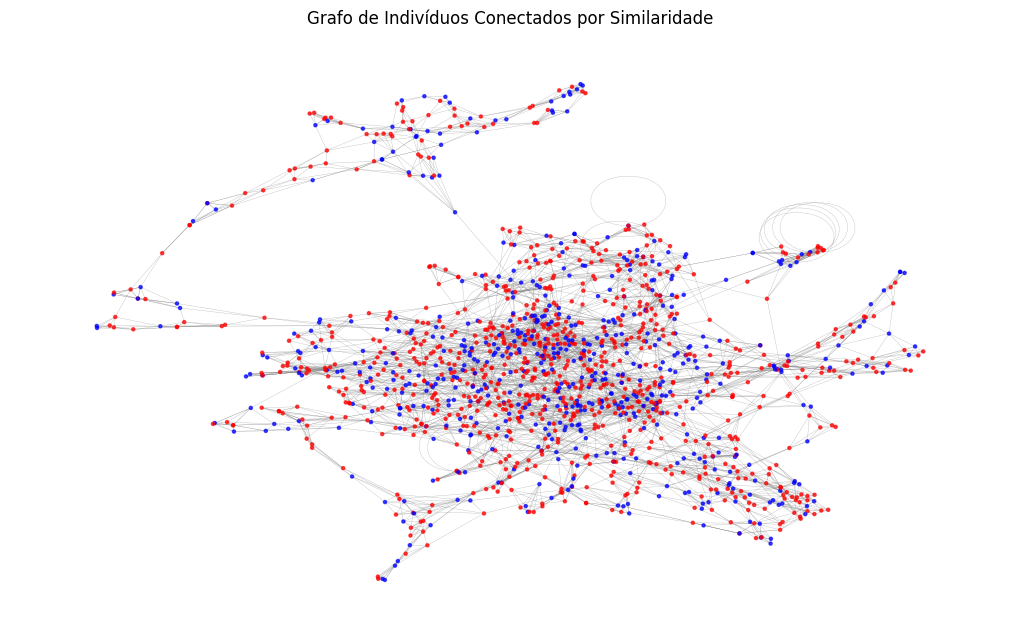

In [68]:
# Criar e visualizar o grafo de treino

graph_train = df_to_pyg_with_edges(X_train, y_train, k=5)
plot_graph(graph_train, db_encoded)

## Grafo de teste

<ipython-input-64-3ca0df427f60>:5: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X = X.fillna(0).astype(np.float32)  # Substitui NaN por 0 (ou outro valor apropriado)


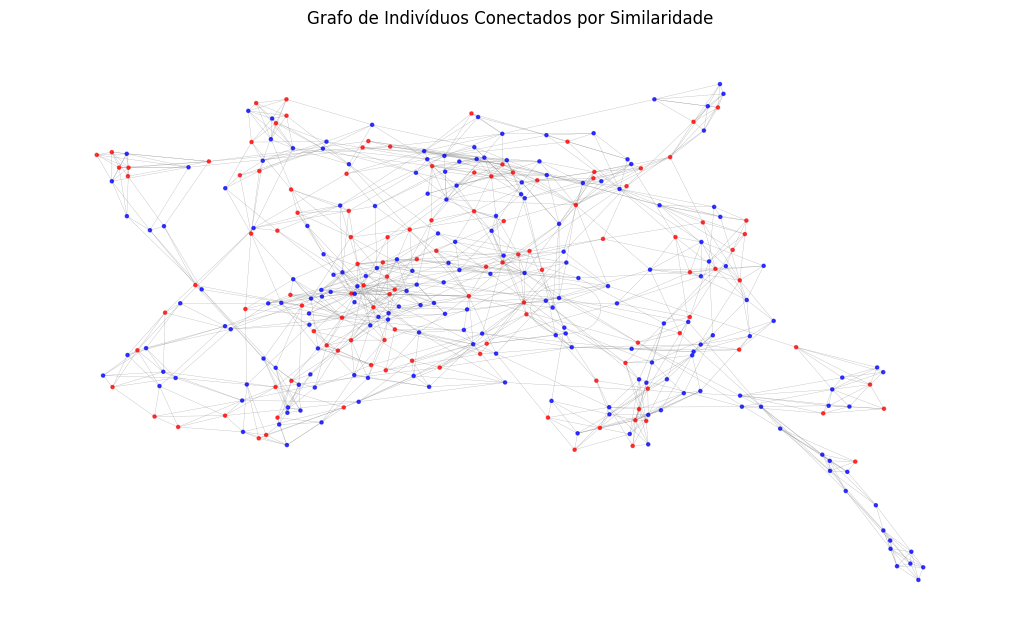

In [69]:
# Criar e visualizar o grafo de teste

graph_test = df_to_pyg_with_edges(X_test, y_test, k=5)
plot_graph(graph_test, db_encoded)

## Grafo de validação

<ipython-input-64-3ca0df427f60>:5: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X = X.fillna(0).astype(np.float32)  # Substitui NaN por 0 (ou outro valor apropriado)


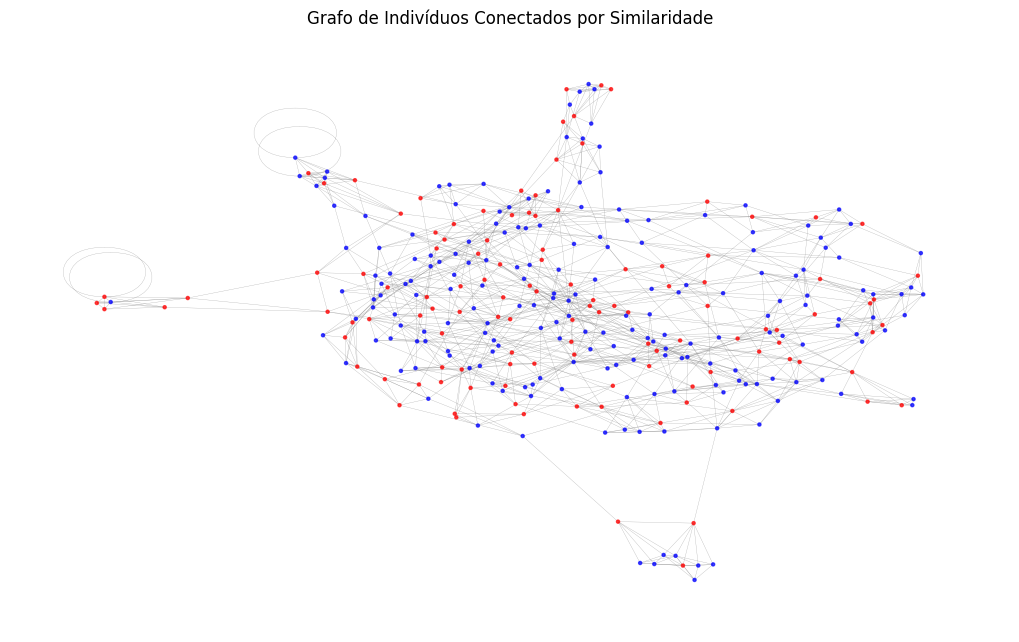

In [70]:
# Criar e visualizar o grafo de validacao

graph_train = df_to_pyg_with_edges(X_val, y_val, k=5)
plot_graph(graph_val, db_encoded)

In [71]:
from google.colab import files

# salvando o grafo de treinamento:
torch.save(graph_train, 'graph_train.pt')

# salvando o grafo de teste:
torch.save(graph_test, 'graph_test.pt')

# salvando o grafo de validação:
torch.save(graph_val, 'graph_val.pt')